In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']  = "1"
os.environ['CUDA_VISIBLE_DEVICES'] 

'1'

In [3]:
from transformers import BertForSequenceClassification, BertTokenizerFast, Trainer, TrainingArguments
from transformers import TFBertForSequenceClassification

from pathlib import Path
from tqdm.auto import tqdm

from nlp import load_dataset
import numpy as np
import pandas as pd
import json
import tensorflow as tf
import torch
import matplotlib.pyplot as plt
import ast

import torch
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader
from transformers import BertForSequenceClassification, AdamW


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score

import sys
#root_project = "/content/Rest/"
root_project = "/storagenfs/a.cudazzo1/ReSt/"
#root_project = "/Users/Alessandro/Dev/repos/SaRaH/"
#root_project = "/home/jupyter/SaRaH/"
sys.path.append(root_project)
from src.data.utils import load_data, set_unkmark_token
from src.utils import metrics
from src.data.word_embedding import get_index_key_association, get_int_seq, build_keras_embedding_matrix, get_data_to_emb
from src.utils.utils import plotHistory, plotF1_macro, plotLoss
from src.utils.metrics import f1_macro



%load_ext autoreload
%autoreload 2

In [5]:
def read_evalita_split(df):
    texts = []
    labels = []
    for index, row in df.iterrows():
        texts.append(row['tokens'])
        labels.append(row['stereotype'])
    return texts, labels

class EvalitaDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Dataset

In [6]:
dataset_dev_path   = root_project + "dataset/haspeede2/preprocessed/dev/dev.csv"
dataset_test_tweets_path   = root_project + "dataset/haspeede2/preprocessed/reference/reference_tweets.csv"

df = pd.read_csv(dataset_dev_path, sep='\t')
df = df[['tokens','stereotype']]

df_test = pd.read_csv(dataset_test_tweets_path, sep='\t')
df_test = df_test[['tokens','stereotype']]

In [7]:
X, y = read_evalita_split(df)
#y  = np.array([[1, 0] if elem==0 else [0, 1] for elem in y])
X_test, y_test = read_evalita_split(df_test)
#y_test  = np.array([[1, 0] if elem==0 else [0, 1] for elem in y_test])

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20)

# Bert tokenizer 

In [9]:
model_name = "dbmdz/bert-base-italian-uncased"
tokenizer = BertTokenizerFast.from_pretrained(model_name)

In [10]:
max_length = 50
X_train_e = tokenizer(X_train, truncation=True, padding=True, max_length = max_length)
X_val_e = tokenizer(X_val, truncation=True, padding=True, max_length = max_length)
X_test_e = tokenizer(X_test, truncation=True, padding=True, max_length = max_length)

In [11]:
X_train_e.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

# To Tourch dataset

In [12]:
train_dataset = EvalitaDataset(X_train_e, y_train)
val_dataset = EvalitaDataset(X_val_e, y_val)
test_dataset = EvalitaDataset(X_test_e, y_test)

## Tourch loader

In [13]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

# Training

In [12]:
from torch.utils.data import DataLoader
from transformers import BertForSequenceClassification, AdamW

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = BertForSequenceClassification.from_pretrained(model_name)
model.to(device)


optim = AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)
num_epochs = 3
num_training_steps = num_epochs * len(train_loader)


m = torch.nn.Softmax(dim=1)
min_valid_loss = np.inf
history = {"loss": [],
           "val_loss": [],
           "f1_macro": [],
           "val_f1_macro": []
          }

progress_bar = tqdm(range(num_training_steps))


for epoch in range(num_epochs):
    train_loss = 0.0
    train_f1_macro = 0.0
    val_loss = 0.0
    val_f1_macro = 0.0
    model.train()
    for i, batch in enumerate(train_loader, 0):
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        loss.backward()
        optim.step()
        # print statistics
        train_loss += loss.item()
        prediction = np.argmax(m(outputs["logits"]).cpu().detach().numpy(), axis = 1).tolist()
        train_f1_macro += f1_score(batch['labels'], prediction, average="macro")
        progress_bar.update(1)
    
    model.eval()     # Optional when not using Model Specific layer
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        val_loss += loss.item()
        prediction = np.argmax(m(outputs["logits"]).cpu().detach().numpy(), axis = 1).tolist()
        val_f1_macro += f1_score(batch['labels'], prediction, average="macro")
    
    history["loss"].append(train_loss / len(train_loader))
    history["val_loss"].append(val_loss / len(val_loader))
    history["f1_macro"].append(train_f1_macro / len(train_loader))
    history["val_f1_macro"].append(val_f1_macro / len(val_loader))
    
    print(f'Epoch {epoch+1} \t loss: {train_loss / len(train_loader)} \t val_loss: {val_loss / len(val_loader)} \t f1_macro: {train_f1_macro/len(train_loader)} \t val_f1_macro: {val_f1_macro/len(val_loader)}')
    if min_valid_loss > (val_loss /len(val_loader)):
        print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{(val_loss /len(val_loader)):.6f}) \t Saving The Model')
        min_valid_loss = (val_loss / len(val_loader))
        # Saving State Dict
        torch.save(model.state_dict(), 'saved_model.pth')
model.eval()
print()

Some weights of the model checkpoint at dbmdz/bert-base-italian-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model

Epoch 1 	 loss: 0.6093229546881559 	 val_loss: 0.5588924633555634 	 f1_macro: 0.6118234904259938 	 val_f1_macro: 0.7059197184182159
Validation Loss Decreased(inf--->0.558892) 	 Saving The Model
Epoch 2 	 loss: 0.45113446406627955 	 val_loss: 0.5268815171926521 	 f1_macro: 0.7698402632285876 	 val_f1_macro: 0.7188789683731961
Validation Loss Decreased(0.558892--->0.526882) 	 Saving The Model
Epoch 3 	 loss: 0.26201074453865925 	 val_loss: 0.8429069965211458 	 f1_macro: 0.8873100995839373 	 val_f1_macro: 0.6786939654159181



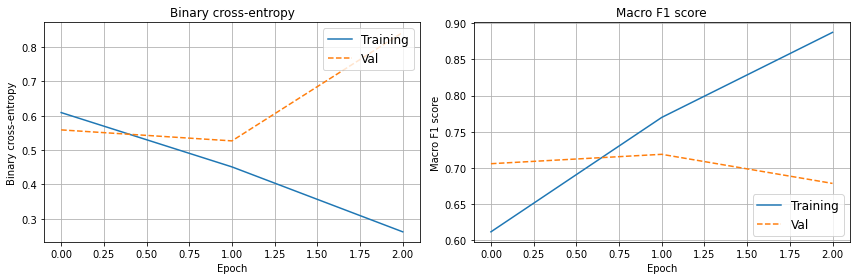

In [13]:
plotHistory(history)

In [14]:
model = BertForSequenceClassification.from_pretrained(model_name)
model.load_state_dict(torch.load('saved_model.pth'))
model.to(device)
print()

Some weights of the model checkpoint at dbmdz/bert-base-italian-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model

In [19]:
model.eval()
m = torch.nn.Softmax(dim=1)
tot_loss = []
prediction = []
true_value = []

with torch.no_grad():
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        # calculate outputs by running images through the network
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        true_value += batch['labels']
        prediction += np.argmax(m(outputs["logits"]).cpu().numpy(), axis = 1).tolist()
        tot_loss.append(outputs[0].cpu().numpy())
print(np.mean(tot_loss))

print(f1_score(true_value, prediction, average="macro"))
print(classification_report(true_value, prediction))

0.2658
0.9310379390860755
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      3048
           1       0.90      0.95      0.92      2423

    accuracy                           0.93      5471
   macro avg       0.93      0.93      0.93      5471
weighted avg       0.93      0.93      0.93      5471



In [18]:
model.eval()
m = torch.nn.Softmax(dim=1)
tot_loss = []
prediction = []
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        # calculate outputs by running images through the network
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        prediction += np.argmax(m(outputs["logits"]).cpu().numpy(), axis = 1).tolist()
        tot_loss.append(outputs[0].cpu().numpy())
print(np.mean(tot_loss))

print(f1_score(y_val, prediction, average="macro"))
print(classification_report(y_val, prediction))

NameError: name 'true_value' is not defined

In [15]:
model.eval()
m = torch.nn.Softmax(dim=1)
tot_loss = []
prediction = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        # calculate outputs by running images through the network
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        prediction += np.argmax(m(outputs["logits"]).cpu().numpy(), axis = 1).tolist()
        tot_loss.append(outputs[0].cpu().numpy())
print(np.mean(tot_loss))

print(f1_score(y_test, prediction, average="macro"))
print(classification_report(y_test, prediction))

0.50690484
0.744951534733441
              precision    recall  f1-score   support

           0       0.81      0.70      0.75       694
           1       0.68      0.80      0.74       569

    accuracy                           0.75      1263
   macro avg       0.75      0.75      0.74      1263
weighted avg       0.76      0.75      0.75      1263



In [44]:
test_dataset

# Gridsearch

In [22]:
def get_model(model_name, hyper_param, device):
    model = BertForSequenceClassification.from_pretrained(model_name)
    model.to(device)
    optim = AdamW(model.parameters(), lr=hyper_param["lr"], weight_decay=hyper_param["weight_decay"])
    return model, optim

def get_data_loader(train_dataset, val_dataset, batch_size  = 16):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    return train_loader, val_loader

def evaluate_model(model, data_loader, device):
    loss = 0.0
    f1_macro = 0.0
    m = torch.nn.Softmax(dim=1)    
    model.eval()     # Optional when not using Model Specific layer
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

            loss += outputs[0].item()
            prediction = np.argmax(m(outputs["logits"]).cpu().detach().numpy(), axis = 1).tolist()
            f1_macro += f1_score(batch['labels'], prediction, average="macro")
    return loss/len(data_loader), f1_macro/len(data_loader)
        
def test_evaluate(model, test_loader, device):
    model.eval()
    m = torch.nn.Softmax(dim=1)
    tot_loss = []
    prediction = []
    true_value = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            # calculate outputs by running images through the network
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            prediction += np.argmax(m(outputs["logits"]).cpu().numpy(), axis = 1).tolist()
            true_value += labels.cpu().numpy().tolist()
            tot_loss.append(outputs[0].cpu().numpy())
    return np.mean(tot_loss), f1_score(true_value, prediction, average="macro")    

def train_model(model, optim, epoch, train_loader, val_loader, device):
    min_valid_loss = np.inf

    history = {"loss": [],
               "val_loss": [],
               "f1_macro": [],
               "val_f1_macro": []
              }
    
    for epoch in range(epoch):
        train_loss = 0.0
        train_f1_macro = 0.0
        val_loss = 0.0
        val_f1_macro = 0.0
        model.train()
        for i, batch in enumerate(train_loader, 0):
            optim.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs[0]
            loss.backward()
            optim.step()
            # print statistics
            train_loss += loss.item()
            prediction = np.argmax(m(outputs["logits"]).cpu().detach().numpy(), axis = 1).tolist()
            train_f1_macro += f1_score(batch['labels'], prediction, average="macro")
        
        train_loss, train_f1_macro = test_evaluate(model, train_loader, device)
        val_loss, val_f1_macro = test_evaluate(model, val_loader, device)


        history["loss"].append(train_loss )
        history["val_loss"].append(val_loss)
        history["f1_macro"].append(train_f1_macro)
        history["val_f1_macro"].append(val_f1_macro)

        print(f'Epoch {epoch+1} \t loss: {train_loss} \t val_loss: {val_loss} \t f1_macro: {train_f1_macro} \t val_f1_macro: {val_f1_macro}')
        if min_valid_loss > (val_loss):
            print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{(val_loss):.6f}) \t Saving The Model')
            min_valid_loss = (val_loss)
            # Saving State Dict
            torch.save(model.state_dict(), 'saved_model.pth')
    return history

In [47]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

train_loader, val_loader = get_data_loader(train_dataset, val_dataset, 16)
model, optim = get_model(model_name, {"lr": 5e-5, "weight_decay": 0.01}, device)
history = train_model(model, optim, 3, train_loader, val_loader, device)
model.load_state_dict(torch.load('saved_model.pth'))

Some weights of the model checkpoint at dbmdz/bert-base-italian-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model

Epoch 1 	 loss: 0.4219636917114258 	 val_loss: 0.5332197546958923 	 f1_macro: 0.82253410112334 	 val_f1_macro: 0.7316278311878768
Validation Loss Decreased(inf--->0.533220) 	 Saving The Model
Epoch 2 	 loss: 0.2091813087463379 	 val_loss: 0.5937544703483582 	 f1_macro: 0.9237869293251552 	 val_f1_macro: 0.7190761499806726
Epoch 3 	 loss: 0.06918719410896301 	 val_loss: 0.7213178873062134 	 f1_macro: 0.9833278480704064 	 val_f1_macro: 0.7370455578818975


<All keys matched successfully>

(0.4219264, 0.82253410112334)
(0.53321975, 0.7316278311878768)
(0.5347798, 0.7291412704862523)


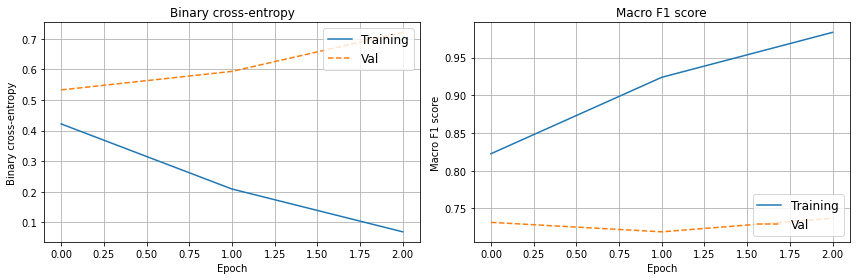

In [48]:
print(test_evaluate(model, train_loader, device))
print(test_evaluate(model, val_loader, device))
print(test_evaluate(model, test_loader, device))
plotHistory(history)

In [27]:
for sentence in X_test[10:15]:
    print(sentence)
    print()

Tutti i politici rubano , hanno rubato e ruberanno ! La Fornero ha rubato 10 mila euro a mio padre ! Ma basta con lecchini di immigrati che si ciondolano tutto il giorno con cellulari stracostosi e sigarette e per noia violentano o rubano ! Vuoi che tuo figlio conosca il Natale o no ?

Rosarno , le case popolari ? Solo a gli immigrati Hanno avuto bisogno di governi non eletti , di gente imposta ad un popolo disarmato . Una volta messi li , i Vigliacchi hanno dato inizio a la ns fine ! Se e quando si scatenerà la rabbia vera , ne farò parte ! !

i musulmano ammazzano tutti quelli che per il loro fumoso cervello sono " infedeli " . i nostri terroristi istituzionali ci obbligano ad accogliere e mantenere i nostri assassini

l' accusa di la sinistraglia cialtrona immigrazionista a < Salvini > è che ha impedito che altri parassiti afro islamici infestassero l' Italia e ha danneggiato il business di l' immigrazione clandestina . Solita feccia rosicona . < Salvini Non Mollare >

A le idiote p

In [26]:
y_test[10:15]

[1, 0, 1, 1, 0]

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = BertForSequenceClassification.from_pretrained(model_name).to(device)
model.load_state_dict(torch.load('saved_model.pth'))
m = torch.nn.Softmax(dim=1)


inputs = tokenizer(X_test[10:15], return_tensors="pt", truncation=True, padding=True, max_length = max_length).to(device)
labels = torch.tensor([1,1,1,1,1]).unsqueeze(0).to(device)  # Batch size 1
outputs = model(**inputs, labels=labels)

In [35]:
np.argmax(m(outputs["logits"]).cpu().detach().numpy(), axis = 1).tolist()

[1, 1, 1, 1, 0]

# "lr": 5e-5, "weight_decay": 0.01, "batch_size": 16

In [23]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

train_loader, val_loader = get_data_loader(train_dataset, val_dataset, 16)
model, optim = get_model(model_name, {"lr": 5e-5, "weight_decay": 0.01}, device)
history = train_model(model, optim, 3, train_loader, val_loader, device)
model.load_state_dict(torch.load('saved_model.pth'))

Some weights of the model checkpoint at dbmdz/bert-base-italian-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model

Epoch 1 	 loss: 0.38966304063796997 	 val_loss: 0.5381200313568115 	 f1_macro: 0.8262391276671244 	 val_f1_macro: 0.7256331038509256
Validation Loss Decreased(inf--->0.538120) 	 Saving The Model
Epoch 2 	 loss: 0.3204294741153717 	 val_loss: 0.5831432938575745 	 f1_macro: 0.888507460603269 	 val_f1_macro: 0.6597877080330232
Epoch 3 	 loss: 0.07526686042547226 	 val_loss: 0.7952704429626465 	 f1_macro: 0.9794097342552013 	 val_f1_macro: 0.7054072771298034


<All keys matched successfully>

(0.38963872, 0.8262391276671244)
(0.53812003, 0.7256331038509256)
(0.5291193, 0.7371336436036833)


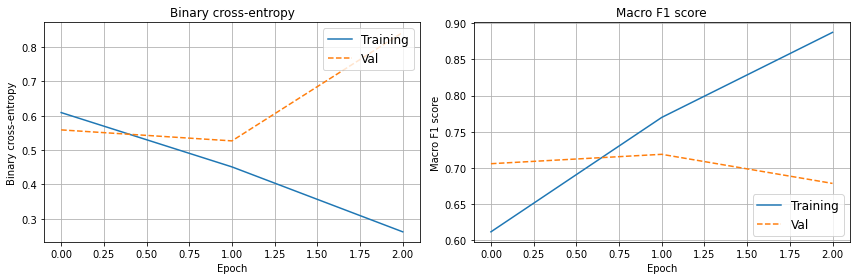

In [28]:
print(test_evaluate(model, train_loader, device))
print(test_evaluate(model, val_loader, device))
print(test_evaluate(model, test_loader, device))
plotHistory(history)

# "lr": 1e-6, "weight_decay": 0.01, "batch_size": 16

In [37]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

train_loader, val_loader = get_data_loader(train_dataset, val_dataset, 16)
model, optim = get_model(model_name, {"lr": 1e-6, "weight_decay": 0.01}, device)
history = train_model(model, optim, 10, train_loader, val_loader, device)
model.load_state_dict(torch.load('saved_model.pth'))

Some weights of the model checkpoint at dbmdz/bert-base-italian-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model

Epoch 1 	 loss: 0.667309045791626 	 val_loss: 0.6740927696228027 	 f1_macro: 0.4648363284186442 	 val_f1_macro: 0.4523103009749894
Validation Loss Decreased(inf--->0.674093) 	 Saving The Model
Epoch 2 	 loss: 0.6357696056365967 	 val_loss: 0.6465871930122375 	 f1_macro: 0.6525902377072945 	 val_f1_macro: 0.6195463374521573
Validation Loss Decreased(0.674093--->0.646587) 	 Saving The Model
Epoch 3 	 loss: 0.5987752079963684 	 val_loss: 0.6197624206542969 	 f1_macro: 0.6778478380719375 	 val_f1_macro: 0.6474042753112521
Validation Loss Decreased(0.646587--->0.619762) 	 Saving The Model
Epoch 4 	 loss: 0.5724686980247498 	 val_loss: 0.6009419560432434 	 f1_macro: 0.7017078101277502 	 val_f1_macro: 0.6748637461024669
Validation Loss Decreased(0.619762--->0.600942) 	 Saving The Model
Epoch 6 	 loss: 0.53495854139328 	 val_loss: 0.5836589932441711 	 f1_macro: 0.7259746784925165 	 val_f1_macro: 0.6870676164496019
Validation Loss Decreased(0.588281--->0.583659) 	 Saving The Model
Epoch 7 	 los

<All keys matched successfully>

(0.47850224, 0.7686447667021692)
(0.57263696, 0.694610584710686)
(0.57403374, 0.6874940340124092)


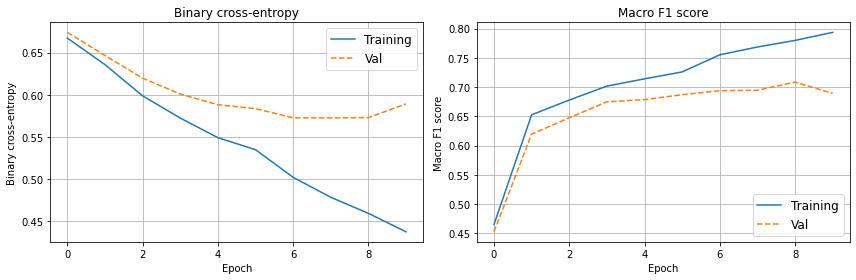

In [38]:
print(test_evaluate(model, train_loader, device))
print(test_evaluate(model, val_loader, device))
print(test_evaluate(model, test_loader, device))
plotHistory(history)

# "lr": 1e-5, "weight_decay": 0.01, "batch_size": 32

In [41]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

train_loader, val_loader = get_data_loader(train_dataset, val_dataset, 32)
model, optim = get_model(model_name, {"lr": 1e-5, "weight_decay": 0.01}, device)
history = train_model(model, optim, 10, train_loader, val_loader, device)
model.load_state_dict(torch.load('saved_model.pth'))

Some weights of the model checkpoint at dbmdz/bert-base-italian-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model

Epoch 1 	 loss: 0.5326918363571167 	 val_loss: 0.5727298855781555 	 f1_macro: 0.7345995485725512 	 val_f1_macro: 0.7032157399194194
Validation Loss Decreased(inf--->0.572730) 	 Saving The Model
Epoch 2 	 loss: 0.4145708680152893 	 val_loss: 0.5622574090957642 	 f1_macro: 0.8175915128509138 	 val_f1_macro: 0.7093746951516926
Validation Loss Decreased(0.572730--->0.562257) 	 Saving The Model
Epoch 3 	 loss: 0.28605887293815613 	 val_loss: 0.5983858108520508 	 f1_macro: 0.8905411449130816 	 val_f1_macro: 0.6941127746006008
Epoch 4 	 loss: 0.14203716814517975 	 val_loss: 0.6526874899864197 	 f1_macro: 0.955306838254734 	 val_f1_macro: 0.7231813744773227
Epoch 5 	 loss: 0.07587022334337234 	 val_loss: 0.8138232827186584 	 f1_macro: 0.9801243521155774 	 val_f1_macro: 0.7093978895096213
Epoch 6 	 loss: 0.03284503519535065 	 val_loss: 0.8991339802742004 	 f1_macro: 0.9925907868987887 	 val_f1_macro: 0.7108424355949108
Epoch 7 	 loss: 0.015810398384928703 	 val_loss: 1.0393269062042236 	 f1_mac

<All keys matched successfully>

(0.41458738, 0.8175915128509138)
(0.5622574, 0.7093746951516926)
(0.5375013, 0.7323092088431382)


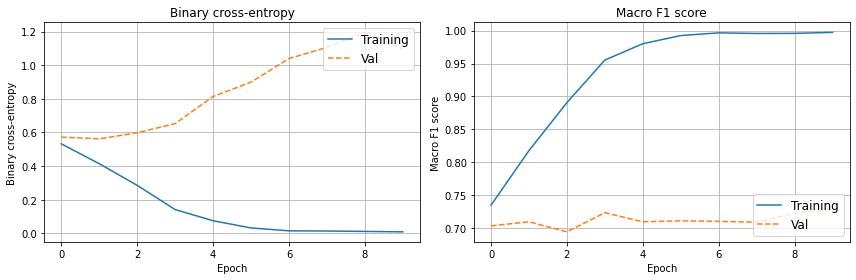

In [42]:
print(test_evaluate(model, train_loader, device))
print(test_evaluate(model, val_loader, device))
print(test_evaluate(model, test_loader, device))
plotHistory(history)

In [43]:
model.load_state_dict(torch.load('saved_model.pth'))
print(test_evaluate(model, train_loader, device))
print(test_evaluate(model, val_loader, device))
print(test_evaluate(model, test_loader, device))

(0.41459173, 0.8175915128509138)
(0.5622574, 0.7093746951516926)
(0.5375013, 0.7323092088431382)
